# 1.4.2.5 Challenge: Boston Marathon

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on [runners and their performance for the Boston Marathon](https://github.com/llimllib/bostonmarathon). Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton"
value="Show Code"></form>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpcol
import seaborn as sns
import scipy
%matplotlib inline

# 1) Data Overview

Let's take a look at a preview of our data to see what we are dealing with.

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


# 2) Data Cleaning

Let's clean up the data by converting some data types and restructuring some columns. This will help us run our models and create some nice visualizations.<br><br>

First let's start by creating a heatmap to see which columns are missing significant data.

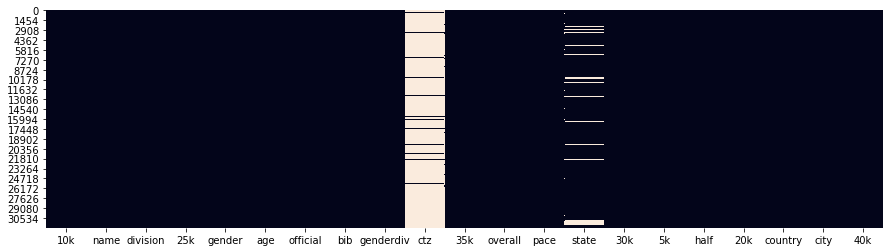

In [6]:
# Plot if any columns have missing data
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(), cbar = False)
plt.show()

Based on this, it seems we can delete the CTZ column as nearly every single row is missing data in that column. As for the STATE column, it makes sense that runners from countries outside the US would have empty values in the STATE column so we will let that slide here.

In [7]:
# Drop the CTZ column as most of the values in that column are NaN.
df.drop(['ctz'], 1, inplace=True)

Let's continue by making sure all checkpoint data is in a numerical type. The checkpoint data is currently split into eight seperate columns and spread out all over the dataset.

In [8]:
# Create a variable for all checkpoint data and convert them to FLOAT dtypes. 
# The 'OFFICIAL' column is already an INT so we will add it in later.
checkpoints = ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']
for i in checkpoints:
    df[i] = df[i].str.replace('-','0.0').astype(float)
    df[i] = df[i].astype(float)

# Add the 'OFFICIAL' column into the CHECKPOINTS variable
checkpoints.append('official')

In [9]:
df[checkpoints].head()

,5k,10k,20k,half,25k,30k,35k,40k,official
0,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25
1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95
2,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60
3,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58
4,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23


Next let's convert the values in the AGE column into age brackets. This will allow us to minimize the unique values in the column and will provide better visualization capabilities. To do so, let's use the age brackets created by the Boston Athletic Association as seen [here](https://www.baa.org/races/boston-marathon/enter/qualify/history-qualifying-times).

In [10]:
# Create a dictionary of the age brackets and the ages assigned to them
age_brackets = {'18-34':(18,34),
                '35-39':(35,39),
                '40-44':(40,44),
                '45-49':(45,49),
                '50-54':(50,54),
                '55-59':(55,59),
                '60-64':(60,64),
                '65-69':(65,69),
                '70-74':(70,74),
                '75-79':(75,79),
                '80+':(80,84)}

# Create a function that will assign each age value into an age bracket
def age_to_bracket(x):    
    for bracket in age_brackets: 
        if age_brackets[bracket][0] <= x <= age_brackets[bracket][1]:
            return bracket               
    else: 
        print('Age value -{}- could not be assigned into a bucket'.format(x))
        return np.nan

# Create a new column using the values created by applying the age bracket function
df['Age Bracket'] = df['age'].apply(lambda x: age_to_bracket(x))

In [11]:
df['Age Bracket'].head()

0    45-49
1    18-34
2    40-44
3    18-34
4    40-44
Name: Age Bracket, dtype: object

Now let's convert the values in the BIB column into wave brackets. This will also allow us to minimize the unique values in the column and will provide better visualization capabilities. To do so, let's use the wave brackets created by the Boston Athletic Association as seen [here](http://registration.baa.org/2014/cf/Public/iframe_EntryLists.cfm).

In [12]:
wave_brackets = {'Elite':(0,100), 
                 'Wave1':(101,8999), 
                 'Wave2':(9000,17999), 
                 'Wave3':(18000,26999), 
                 'Wave4':(27000,50000)}

# Create a function that will assign each bib value into a wave bracket
def bib_to_wave(x):   
    try:
        for wave in wave_brackets:
            if wave_brackets[wave][0] <= float(x) <= wave_brackets[wave][1]: return wave
    except ValueError:
        if 'W' or 'F' in str(x): return 'Elite'
    else: 
        print(float(x))
        return np.nan

# Create a new column using the values created by applying the wave bracket function
df['Wave'] = df['bib'].apply(lambda x: bib_to_wave(x))

In [13]:
df['Wave'].head()

0    Elite
1    Elite
2    Elite
3    Elite
4    Elite
Name: Wave, dtype: object

Here we will convert the values in the COUNTRY column. According to the Boston Athletic Association, only five countries had over 200 participants in the 2014 Boston Marathon - __USA, Canada, United Kingdom, Italy, and Mexico__. Therefore, let's convert all other COUNTRY values to now say "OTHER". This will also allow us to minimize the unique values in the column and will provide better visualization capabilities.<br><br>

After that we will convert the __Gender__ column into binary 1 / 0 for use in our clustering models. 

In [14]:
# Make a variable of the country tags we will be using
countries = ['USA', 'CAN', 'GBR', 'ITA', 'MEX']

# Assign all other countries with the value "OTHER"
df['Country'] = df['country'].apply(lambda x: np.where(x not in countries, 'OTHER', x))

In [15]:
df['Country'].head()

0    OTHER
1    OTHER
2    OTHER
3    OTHER
4    OTHER
Name: Country, dtype: object

In [16]:
# Binarize the gender variable for use in our cluster modeling
df['male'] = df['gender'].apply(lambda x: np.where(x == 'M', 1, 0))
df['male'].head()

0    1
1    0
2    1
3    0
4    1
Name: male, dtype: int64

# 3) Data Analysis

It looks like our data is now relatively clean. Let's make some visualization to have a better understanding of the dataset we are dealing with.<br><br>

First let's see how the participant counts compare by __gender__.

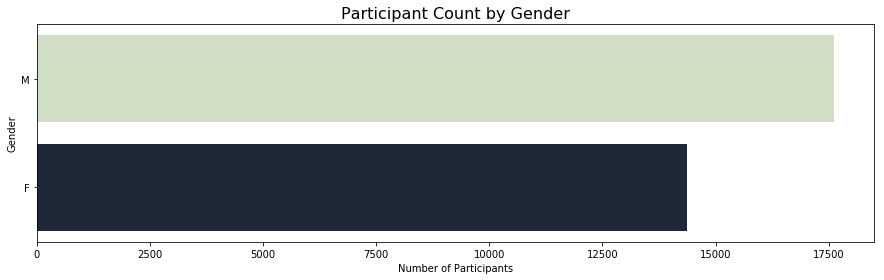

In [17]:
# Create a countplot for Male and Female participants
plt.figure(figsize=(15,4))
sns.countplot(y=df['gender'], palette = sns.cubehelix_palette(2, rot = -0.5))
plt.title('Participant Count by Gender', fontsize=16)
plt.xlabel('Number of Participants')
plt.ylabel('Gender')
plt.show()

Next let's see the __age count by gender__.

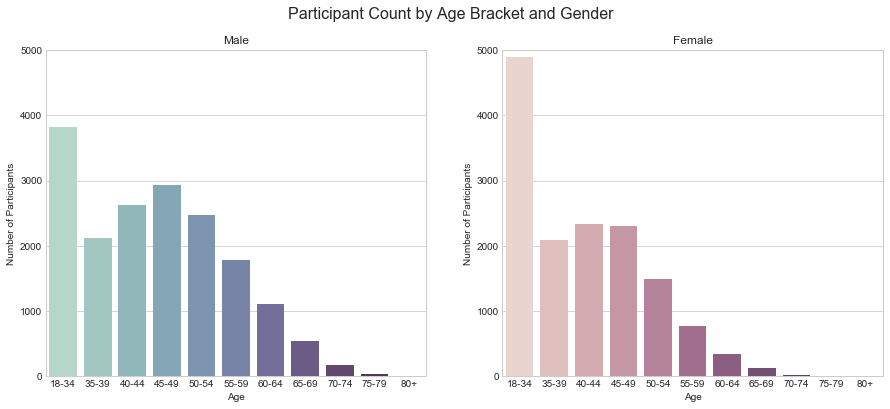

In [18]:
# Create a countplot for participant ages by gender
plt.style.use('seaborn-whitegrid')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Participant Count by Age Bracket and Gender', fontsize=16)

male   = df[df['gender'] == 'M']['Age Bracket']
female = df[df['gender'] == 'F']['Age Bracket']
frames = [male, female]
labels = ['Male', 'Female']

palettes = {}
palettes['Male']   = sns.cubehelix_palette(len(age_brackets), start=1, rot=-0.75, 
                                           light=0.8, dark=0.2)
palettes['Female'] = sns.cubehelix_palette(len(age_brackets))

for idx, ax in enumerate([ax0, ax1]):
    sns.countplot(frames[idx], ax = ax, 
                  order = age_brackets,
                  palette = palettes[labels[idx]],
                  label = labels[idx])
    ax.set(ylim = (0, 5000), ylabel = 'Number of Participants', xlabel = 'Age')
    ax.set_title(labels[idx])

Here let's make a barplot of the participants' nationalities.

In [19]:
# Create a value-count table to see the counts of runners from each country
country_sort = df['Country'].value_counts(ascending=True)
country_sort = country_sort.to_frame()

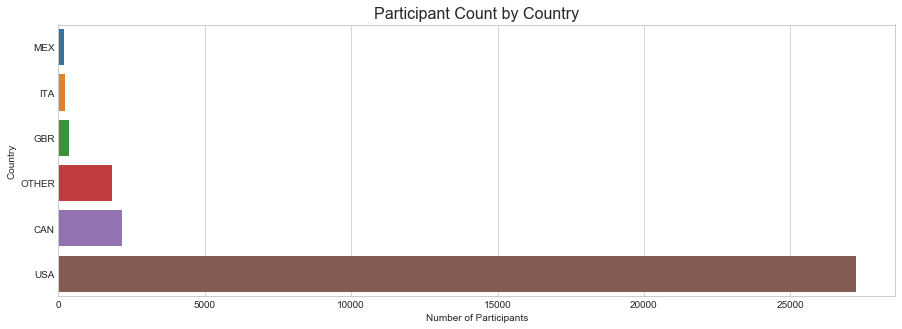

In [20]:
# Create a countplot for Male and Female participants
plt.figure(figsize=(15,5))
sns.barplot(x = 'Country', y = country_sort.index, data = country_sort)
plt.title('Participant Count by Country', fontsize=16)
plt.xlabel('Number of Participants')
plt.ylabel('Country')
plt.show()

Now let's see how many runners participated in each wave.

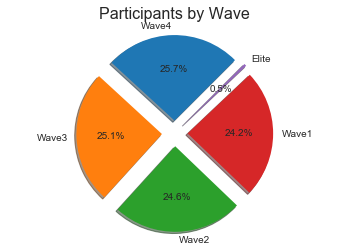

In [21]:
# Create a dataframe of the wave information
wave_df = df['Wave'].value_counts().to_frame()

# Create a pie chart for waves
plt.pie(wave_df['Wave'], explode = (0.15, 0.15, 0.15, 0.15, 0.15), labels = wave_df.index,
autopct = '%1.1f%%', shadow = True, startangle = 45)
plt.title('Participants by Wave', fontsize=16) 
plt.axis('equal')
plt.show()

Here let's see how each gender faired at each checkpoint.

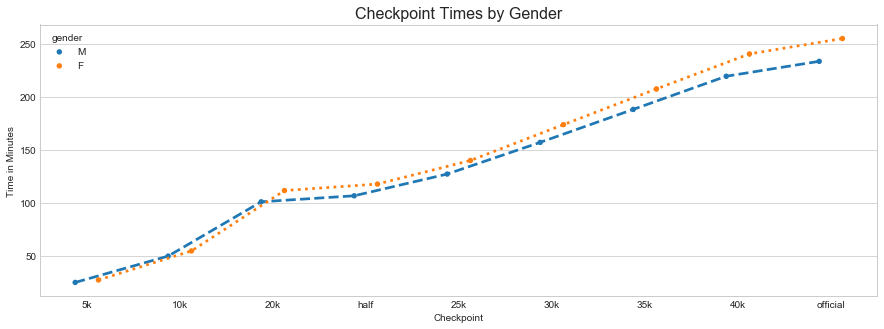

In [22]:
# Create a new dataframe that melts the checkpoint data by gender
stacked_checkpoints = pd.melt(df, value_vars = checkpoints, var_name='checkpoint',
                              value_name='time', id_vars=['gender'])

plt.figure(figsize=(15,5))
sns.pointplot(data=stacked_checkpoints, x='checkpoint', y='time', hue='gender',
                   markers=['.','.'], linestyles=['--', ':'], ci=95, orient="v", 
                   dodge=0.25)

plt.title('Checkpoint Times by Gender', fontsize=16)
plt.ylabel('Time in Minutes')
plt.xlabel('Checkpoint')
plt.show()

# 4) Modeling

In [23]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

First let's create a dataframe of all the features we will be using.

In [24]:
df.head(2)

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,...,5k,half,20k,country,city,40k,Age Bracket,Wave,Country,male
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,...,8.02,39.72,37.65,JPN,Fukuoka,80.43,45-49,Elite,OTHER,1
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,...,16.22,69.47,65.83,KEN,Eldoret,132.10,18-34,Elite,OTHER,0


In [25]:
# Create a blank dataframe called 'modeling_df'
modeling_df = pd.DataFrame()

# Add the columns that are already in the correct format
modeling_df['age'] = df['age']
modeling_df['male'] = df['male']
modeling_df['division'] = df['division']
modeling_df['genderdiv'] = df['genderdiv']
modeling_df['overall'] = df['overall']

# Add checkpoint values as seperate columns
for checkpoint in checkpoints:
    modeling_df[checkpoint] = df[checkpoint]

# Add countries with significant levels of participation as binary columns
# First add the 'OTHER' country value into the variable called 'countries'
countries.append('OTHER')
for country in countries:
    modeling_df[country] = np.where(df['Country'] == country, 1, 0)

modeling_df.head()

,age,male,division,genderdiv,overall,5k,10k,20k,half,25k,30k,35k,40k,official,USA,CAN,GBR,ITA,MEX,OTHER
0,47,1,8,8,8,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25,0,0,0,0,0,1
1,33,0,1,1,21,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,0,0,0,0,0,1
2,41,1,1,1,1,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,0,0,0,0,0,1
3,24,0,3,3,27,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,0,0,0,0,0,1
4,40,1,2,2,2,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,0,0,0,0,0,1


Many of our features span different scales so let's normalize the data so we can compare the features against each other.

In [26]:
# Normalize the data
X = modeling_df
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_normed = pd.DataFrame(np_scaled, columns=list(modeling_df))
X_normed.head()

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,male,division,genderdiv,overall,5k,10k,20k,half,25k,30k,35k,40k,official,USA,CAN,GBR,ITA,MEX,OTHER
0,0.460317,1.0,0.001003,0.000398,0.000219,0.092237,0.154565,0.167818,0.167829,0.164937,0.157235,0.158903,0.158218,0.010147,0.0,0.0,0.0,0.0,0.0,1.0
1,0.238095,0.0,0.000000,0.000000,0.000626,0.186544,0.289909,0.293425,0.293531,0.285205,0.263909,0.258986,0.259860,0.127324,0.0,0.0,0.0,0.0,0.0,1.0
2,0.365079,1.0,0.000000,0.000000,0.000000,0.089132,0.147891,0.160909,0.160688,0.158467,0.149981,0.150046,0.149700,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,0.095238,0.0,0.000287,0.000114,0.000814,0.186314,0.289820,0.293425,0.293531,0.285205,0.263909,0.258986,0.261532,0.130881,0.0,0.0,0.0,0.0,0.0,1.0
4,0.349206,1.0,0.000143,0.000057,0.000031,0.092237,0.152340,0.163049,0.163096,0.160439,0.151522,0.150958,0.150920,0.001375,0.0,0.0,0.0,0.0,0.0,1.0


Conduct a Principal Component Analysis so we can plot the data on a two dimensional graph.

In [27]:
# Coduct PCA on the normalized dataframe
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_normed)
pca_1 = [x[0] for x in X_pca]
pca_2 = [x[1] for x in X_pca]

# 5) Clustering
## Mean Shift Clustering

In [31]:
# Mean Shift Clustering
bandwidth = estimate_bandwidth(X_normed, quantile = 0.2, n_samples = 500, n_jobs = 1)

# Fit the model
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True)
ms.fit(X_normed)

# Extract cluster assignments for each datapoint
labels = ms.labels_

# Coordinates of the cluser centers
cluster_centers = ms.cluster_centers_

# Count our clusters
n_clusters_ = len(np.unique(labels))
print('Number of estimated clusters: {}'.format(n_clusters_))

ms_labels = ms.predict(X_normed)

Number of estimated clusters: 19


Let's see what the clusters look like.

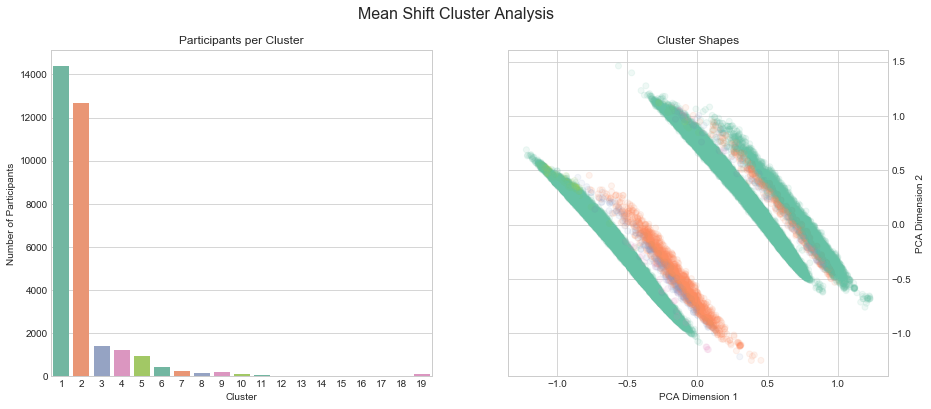

In [32]:
# Add the clusters to the dataframes
modeling_df['cluster'] = ms_labels + 1
df['cluster'] = ms_labels + 1

# Generate color palettes for the plots
palettes['clust_rgb'] = sns.color_palette('Set2', 5).as_hex()
palettes['clust_cmap'] = mpcol.ListedColormap(palettes['clust_rgb'], name='my_name')

plt.figure(figsize=(15,6))

# Create a countplot of the clusters
ax1 = plt.subplot(1, 2, 1)    
sns.countplot(x = modeling_df['cluster'], palette=sns.color_palette(palettes['clust_rgb']))

plt.title('Participants per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Participants')

# Visualize the clusters
ax2 = plt.subplot(1, 2, 2)    
plt.scatter(x = pca_1, y = pca_2, c= modeling_df['cluster'], 
            cmap = palettes['clust_cmap'], alpha=0.1)
plt.title('Cluster Shapes')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.suptitle('Mean Shift Cluster Analysis', fontsize=16)
plt.show()

# 6) Outcome Summary 